# 2. Clustering particional

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from matplotlib import colors as mcolors


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering, Birch, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples
import plotly.express as px




## 2.1 Preprocesamiento de datos

- Eliminación de outliers -> sesgan centroids
- However, tal vez no son outliers sino concentraciones menores de accidentes en otros barrios?
- Quitar estado_meteo
- Normalización

In [3]:
# primero importamos los csv scaled_df, normalized_df y df_grouped

scaled_df = pd.read_csv('scaled_df.csv')
normalized_df = pd.read_csv('normalized_df.csv')
df_grouped = pd.read_csv('df_grouped.csv')
df_prueba101_norm = pd.read_csv('df_prueba101_norm.csv')

In [4]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis

# Función para calcular y filtrar outliers usando Mahalanobis
def filter_outliers_mahalanobis(df, columns, percentile=97.5):
    data = df[columns].values

    # Verificar que no haya valores NaN
    data = data[~np.isnan(data).any(axis=1)]

    # Calcular la media y la matriz de covarianza inversa
    mean = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Calcular las distancias de Mahalanobis
    distances = [mahalanobis(row, mean, inv_cov_matrix) for row in data]

    # Definir el umbral según el percentil deseado
    threshold = np.percentile(distances, percentile)

    # Añadir las distancias al DataFrame
    df['mahalanobis_distance'] = np.nan  # Inicializar columna
    df.loc[~np.isnan(df[columns]).any(axis=1), 'mahalanobis_distance'] = distances

    # Filtrar por el umbral
    return df[df['mahalanobis_distance'] <= threshold]

# Uso de la función
columns_to_check = ['coordenada_x_utm', 'coordenada_y_utm']  # Sustituir con tus columnas
df_filtered = filter_outliers_mahalanobis(normalized_df, columns_to_check, percentile=97.5)


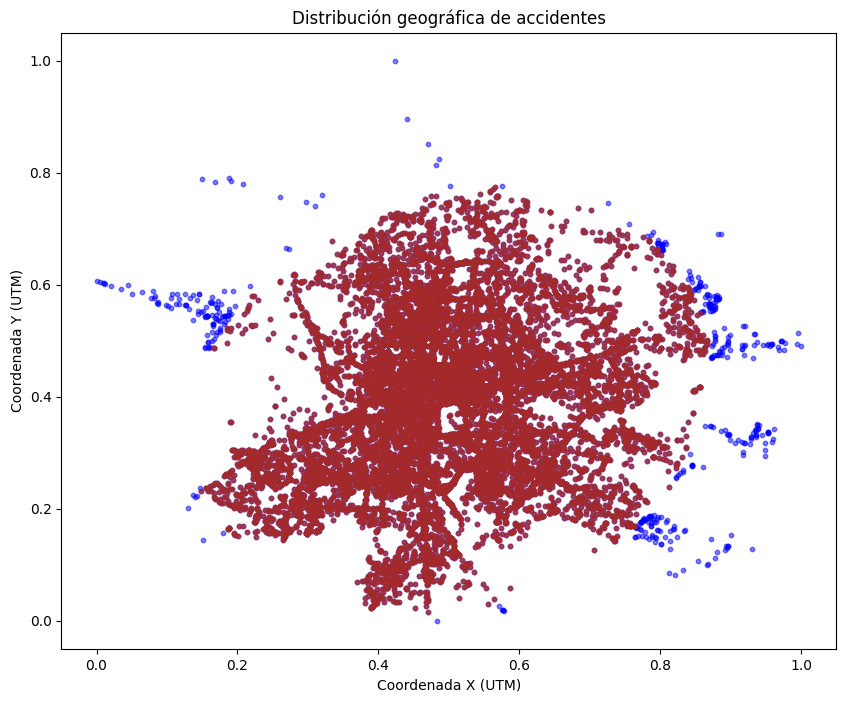

In [5]:
# Scatterplot
plt.figure(figsize=(10, 8))
plt.scatter(normalized_df['coordenada_x_utm'], normalized_df['coordenada_y_utm'], alpha=0.5, s=10, color='blue')
plt.scatter(df_filtered['coordenada_x_utm'], df_filtered['coordenada_y_utm'], alpha=0.7, s=10, color='brown')
plt.title('Distribución geográfica de accidentes')
plt.xlabel('Coordenada X (UTM)')
plt.ylabel('Coordenada Y (UTM)')
plt.show()


El "preprocesamiento necesario para poder aplicar algoritmos de clustering particional" es básicamente la normalización de los datos ya que k-means se basa en distancias. En este caso, ya los hemos normalizado con MinMax scaler en el notebook anterior.

## 2.2 Número óptimo de clusters

#### Elbow method

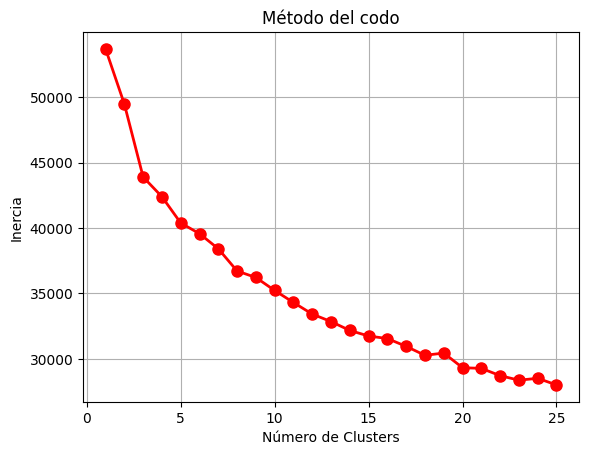

In [12]:
def plot_results(inertials):
   
    x, y = zip(*[inertia for inertia in inertials])
    plt.plot(x, y, 'ro-', markersize=8, lw=2)
    plt.grid(True)
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del codo')
    plt.show()


def select_clusters_from_dataframe(df, loops, max_iterations, init_cluster, tolerance):
    
    # Convertir el dataframe a un array numpy
    points = df

    inertia_clusters = []

    for i in range(1, loops + 1):
        # Crear objeto KMeans
        kmeans = KMeans(
            n_clusters=i,
            max_iter=max_iterations,
            init=init_cluster,
            tol=tolerance
        )

        # Ajustar el modelo
        kmeans.fit(points)

        # Guardar el número de clusters y la inercia
        inertia_clusters.append([i, kmeans.inertia_])

    # Graficar los resultados
    plot_results(inertia_clusters)


# Parámetros constantes
LOOPS = 25
MAX_ITERATIONS = 10
INITIALIZE_CLUSTERS = 'k-means++'
CONVERGENCE_TOLERANCE = 0.001

select_clusters_from_dataframe(
    df=df_prueba101_norm,  # Sustituye con tu dataframe
    loops=LOOPS,
    max_iterations=MAX_ITERATIONS,
    init_cluster=INITIALIZE_CLUSTERS,
    tolerance=CONVERGENCE_TOLERANCE
)


#### Gap

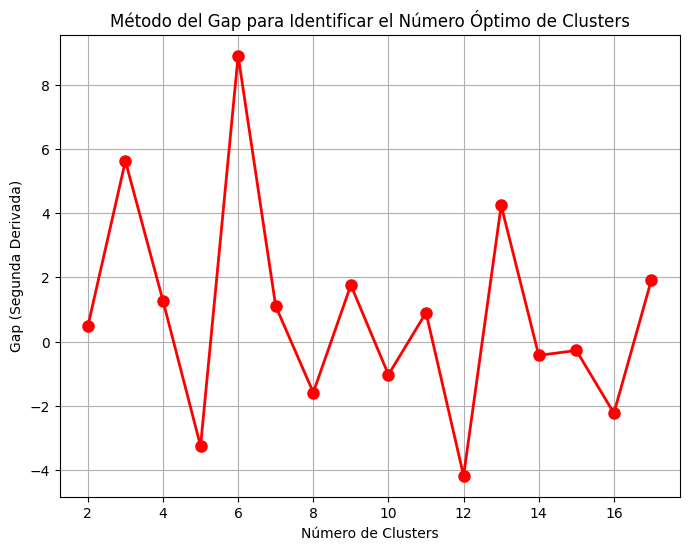

In [6]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage

def plot_gap_from_dataframe(data):
    
    # Asegurarse de que los datos sean numéricos (sin columnas no válidas)
    points = data.select_dtypes(include=[np.number]).values

    # Calcular distancias jerárquicas entre puntos usando el método Ward
    Z = linkage(points, metric='euclidean', method='ward')

    # Obtener las últimas 10 distancias entre puntos o grupos
    last = Z[-18:, 2]
    num_clusters = np.arange(1, len(last) + 1)

    # Calcular el gap (segunda derivada de las distancias)
    gap = np.diff(last, n=2)  # Segunda diferencia (derivada discreta)

    # Visualizar el resultado
    plt.figure(figsize=(8, 6))
    plt.plot(num_clusters[:-2] + 1, gap[::-1], 'ro-', markersize=8, lw=2)
    plt.title('Método del Gap para Identificar el Número Óptimo de Clusters')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Gap (Segunda Derivada)')
    plt.grid(True)
    plt.show()


# Llamar a la función
plot_gap_from_dataframe(df_prueba101_norm)


#### Fuerza bruta

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_clustering_with_k_and_quality_indices(data, k_range=range(2, 10), quality_indices=None):
    # Índices de calidad válidos
    valid_indices = ['inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin']
    if quality_indices is None:
        quality_indices = ['inertia', 'silhouette']
    else:
        # Validar los índices solicitados
        for index in quality_indices:
            if index not in valid_indices:
                raise ValueError(f"Índice de calidad no válido. Elija entre {valid_indices}.")

    # Almacenar los valores de calidad para cada índice
    quality_scores = {index: [] for index in quality_indices}

    # Configurar la cuadrícula de visualización (3x3 para K-means)
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 3 filas y 3 columnas
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for row, k in enumerate(k_range):
        col = row % 3  
        # Aplicar KMeans
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        labels = kmeans.labels_

        # Calcular y almacenar los índices de calidad
        if 'inertia' in quality_indices:
            quality_scores['inertia'].append(kmeans.inertia_)
        if 'silhouette' in quality_indices:
            quality_scores['silhouette'].append(silhouette_score(data, labels))
        if 'calinski_harabasz' in quality_indices:
            quality_scores['calinski_harabasz'].append(calinski_harabasz_score(data, labels))
        if 'davies_bouldin' in quality_indices:
            quality_scores['davies_bouldin'].append(davies_bouldin_score(data, labels))

        # Reducir datos a 2D con PCA para visualización
        pca = PCA(n_components=2)
        data_2D = pca.fit_transform(data)

        # Gráfico de dispersión de clusters coloreados
        sns.scatterplot(
            x=data_2D[:, 0], y=data_2D[:, 1], hue=labels, 
            palette=sns.color_palette("tab10", k), ax=axes[row // 3, col], s=50, legend=None
        )
        axes[row // 3, col].set_title(f"K={k}")
        axes[row // 3, col].set_xlabel('Componente Principal 1')
        axes[row // 3, col].set_ylabel('Componente Principal 2')

    # Mostrar la primera figura (K-means 3x3)
    plt.tight_layout()
    plt.show()

    # Configurar subplots para índices de calidad en una sola fila
    fig, axes = plt.subplots(1, len(quality_indices), figsize=(5 * len(quality_indices), 5))
    if len(quality_indices) == 1:  # Si solo hay un índice, `axes` no será iterable
        axes = [axes]

    for ax, index in zip(axes, quality_indices):
        ax.plot(list(k_range), quality_scores[index], marker='o')
        ax.set_title(f"{index.replace('_', ' ').capitalize()}")
        ax.set_xlabel("Número de Clusters (K)")
        ax.set_ylabel(index.replace('_', ' ').capitalize())
        ax.grid(True)

    plt.tight_layout()
    plt.show()


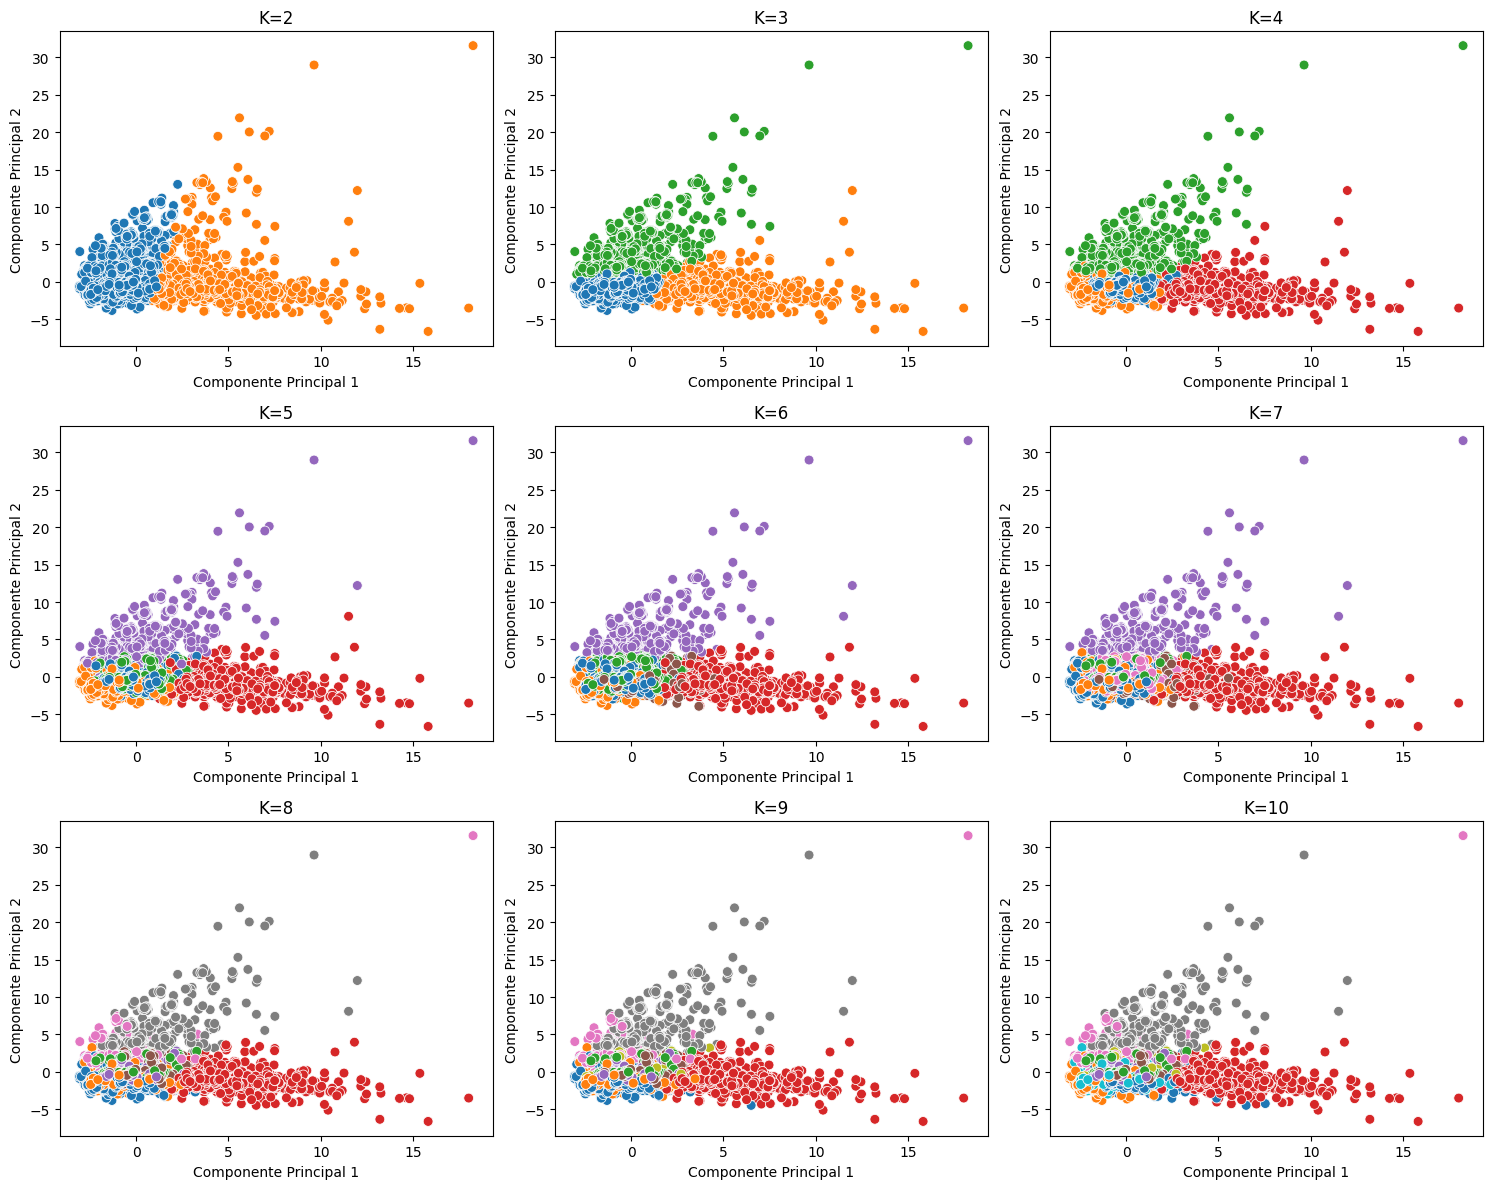

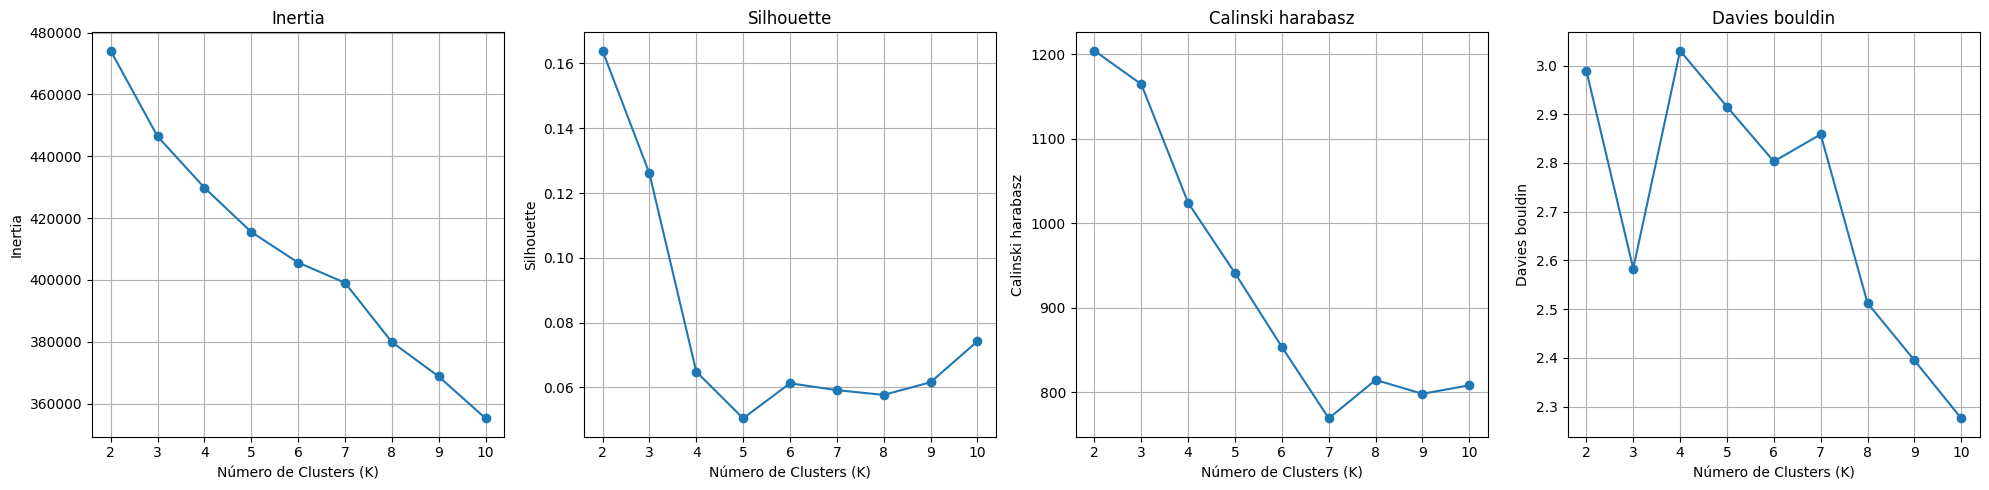

In [ ]:
evaluate_clustering_with_k_and_quality_indices(scaled_df, k_range=range(2, 11), quality_indices=['inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])

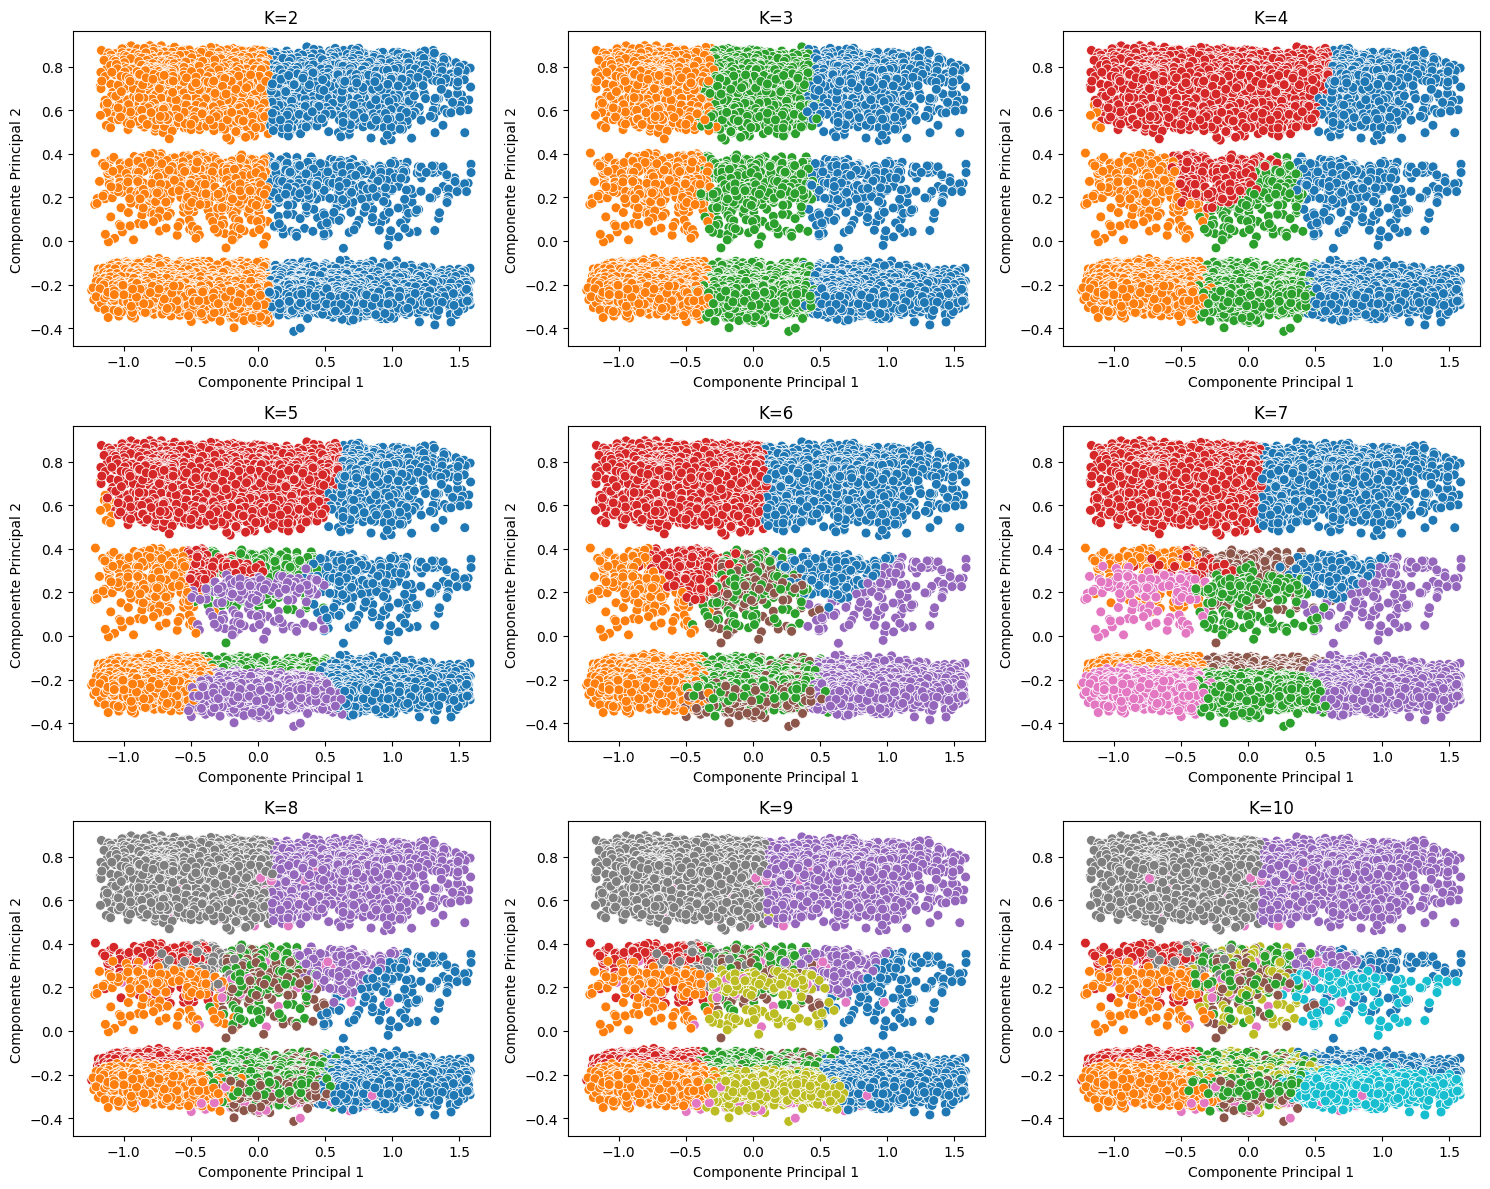

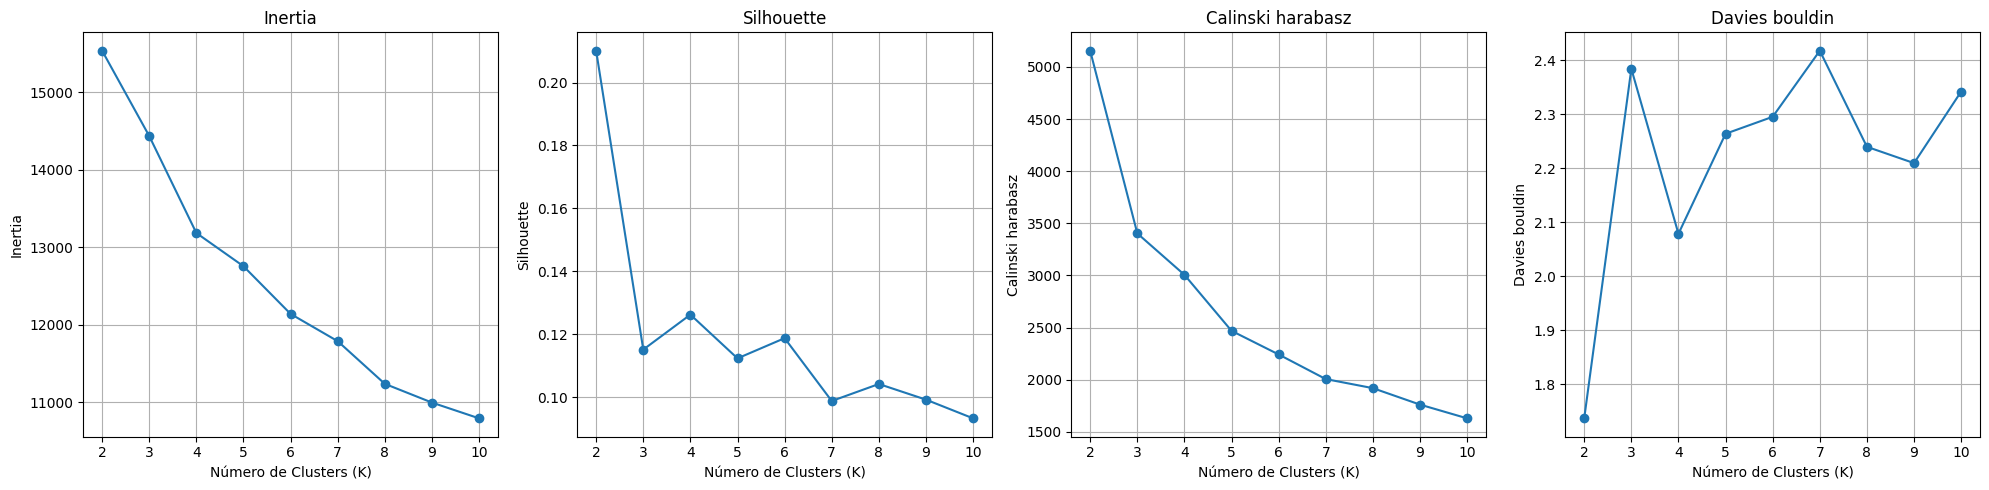

In [ ]:
evaluate_clustering_with_k_and_quality_indices(df_filtered, k_range=range(2, 11), quality_indices=['inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])

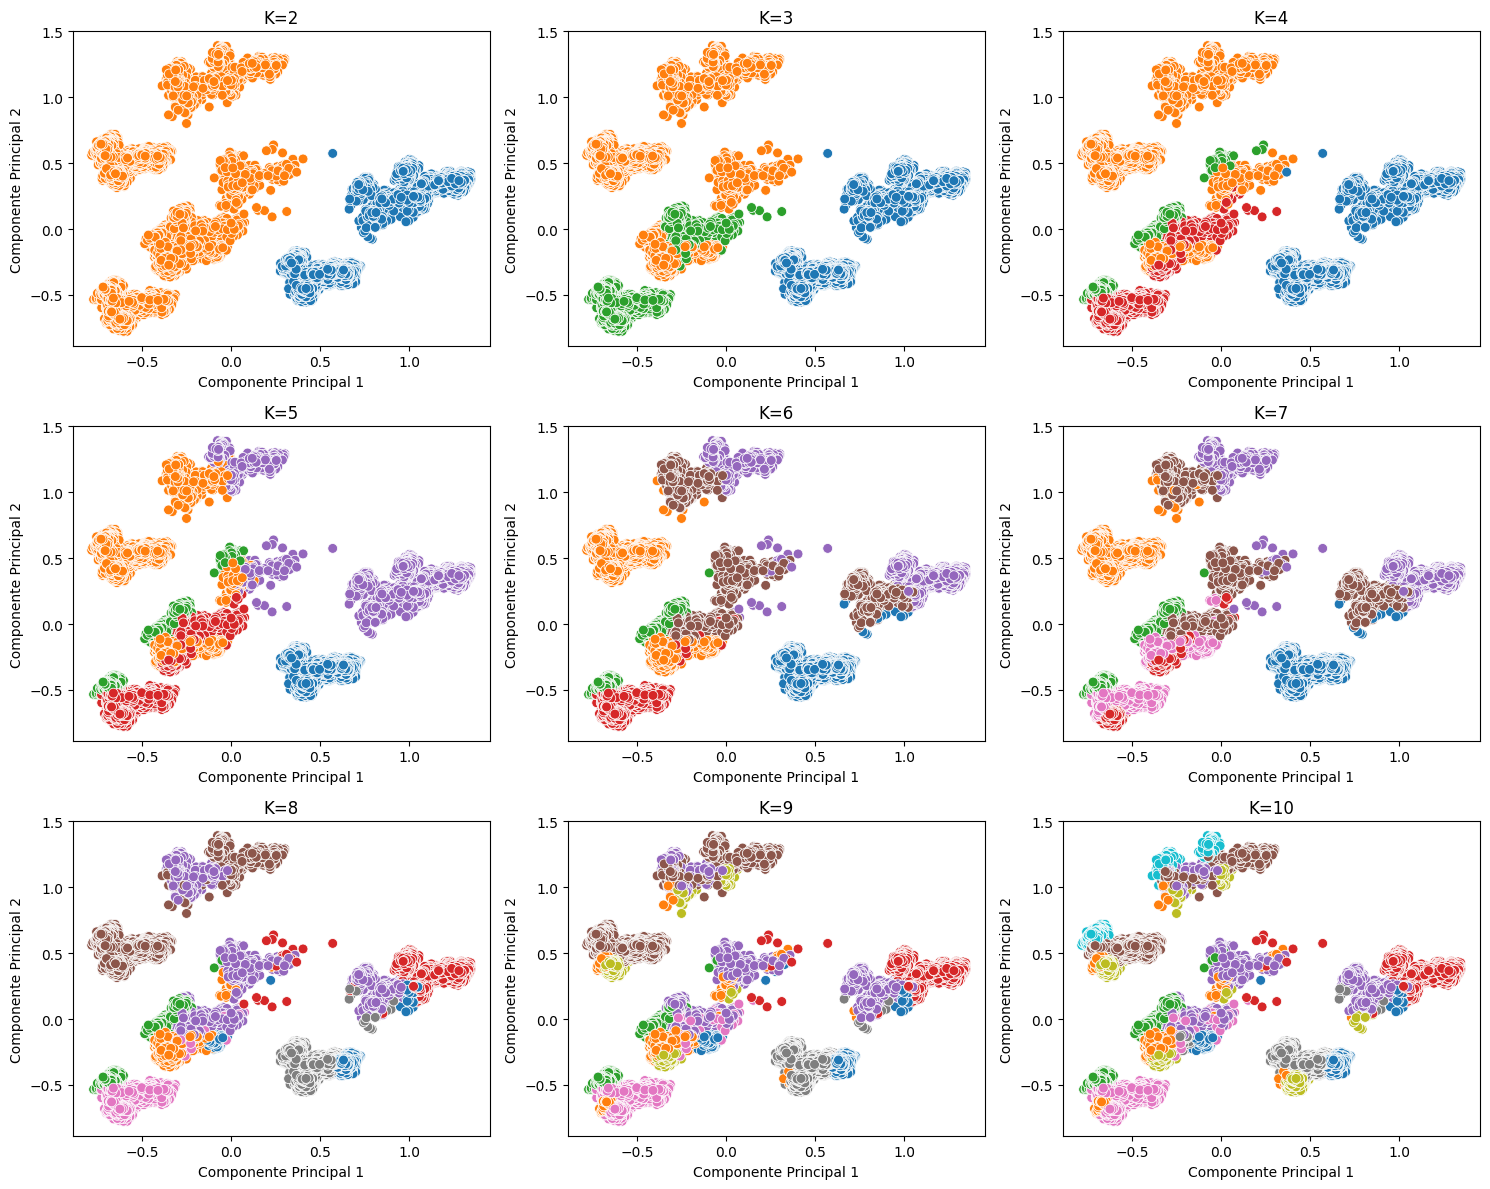

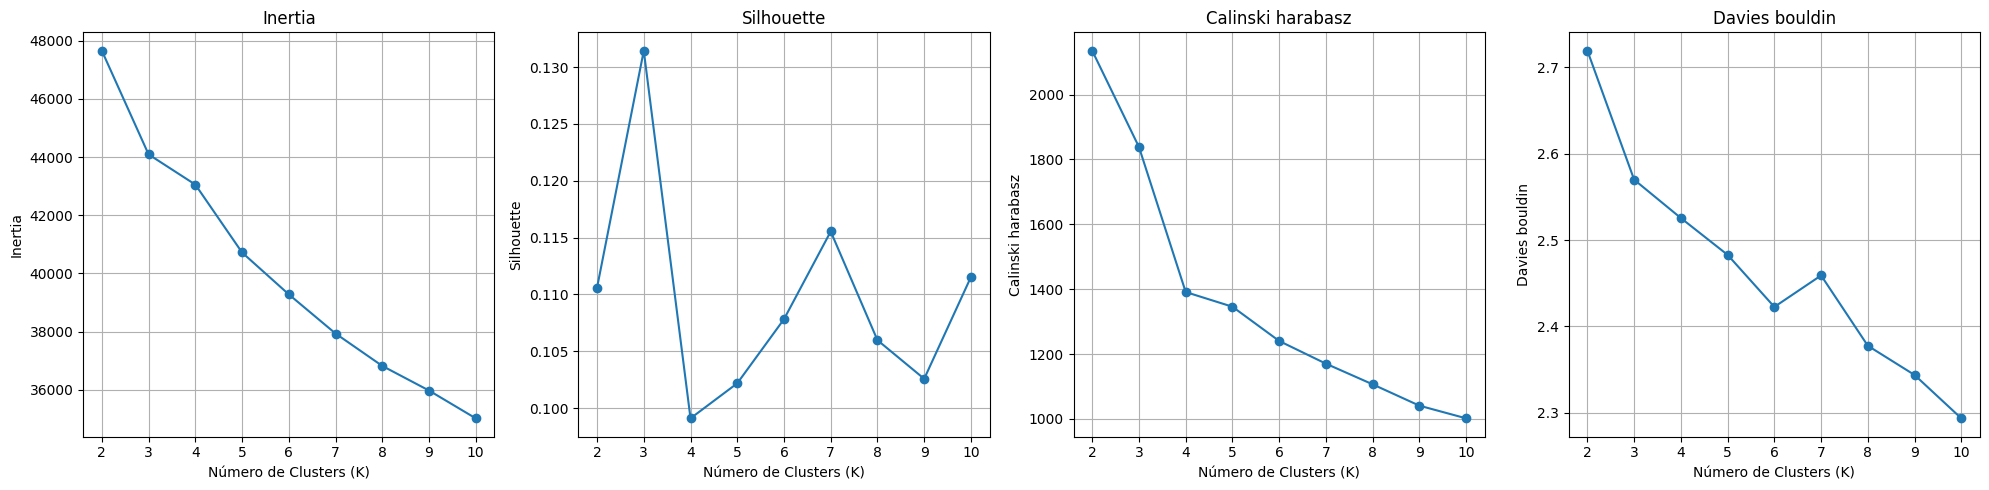

In [17]:
evaluate_clustering_with_k_and_quality_indices(df_prueba101_norm, k_range=range(2, 11), quality_indices=['inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])

In [ ]:
import pandas as pd

# Fit KMeans with optimal number of clusters (e.g., K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_df)

# Add cluster labels to the original dataframe
df_grouped['Cluster'] = clusters

# Analyze clusters by group (mean for example)
cluster_stats = df_grouped.groupby('Cluster').mean()
cluster_stats

,cod_distrito,tipo_accidente,estado_meteorológico,coordenada_x_utm,coordenada_y_utm,fecha_month,fecha_day,hora_hour,hora_minute,sexo_Mujer,...,rango_edad_18-24,rango_edad_25-34,rango_edad_35-44,rango_edad_45-59,rango_edad_60+,tipo_persona_Conductor,tipo_persona_Pasajero,tipo_persona_Peatón,positiva_alcohol,cod_lesividad
Cluster,,,,,,,,,,,,,,,,,,,,,
0,9.408562,4.113645,1.207212,441997.135090,4.474894e+06,5.509999,15.708698,13.694884,26.158381,0.582202,...,0.191230,0.438358,0.439402,0.630070,0.252510,1.740503,0.163923,0.089230,0.059192,1.320777
1,10.024298,4.265119,1.028078,442192.451404,4.474362e+06,5.557775,15.248920,14.190065,26.651188,1.934125,...,0.649028,0.917927,0.854752,1.083153,0.540497,2.327214,2.260259,0.067495,0.081533,1.350432
2,10.913176,4.729246,1.701447,442165.208302,4.474388e+06,5.450114,15.166794,13.170602,25.775324,0.308073,...,0.118050,0.246002,0.222772,0.311500,0.129474,2.404798,0.115765,0.034653,0.093679,0.592536


## 2.3 Calidad de clusters según k

In [8]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

def xie_beni_index(X, labels, centroids):

    n_clusters = len(centroids)
    min_dist = np.min([np.linalg.norm(centroids[i] - centroids[j])
                       for i in range(n_clusters) for j in range(n_clusters) if i != j])

    intra_cluster_distances = np.sum([
        np.linalg.norm(X[labels == i] - centroids[i], axis=1).sum()
        for i in range(n_clusters)
    ])

    return intra_cluster_distances / (X.shape[0] * (min_dist ** 2))

def evaluar_indices_calidad(X, k_min=2, k_max=10, random_state=42):
    
    # Almacenar los resultados
    resultados = {
        'k': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': [],
        'xie_beni': []
    }

    # Iterar sobre los valores de k
    for k in range(k_min, k_max + 1):
        # Crear el modelo KMeans
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(X)
        centroids = kmeans.cluster_centers_

        # Calcular los índices de calidad
        silhouette = silhouette_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        xie_beni = xie_beni_index(X, labels, centroids)

        # Guardar los resultados
        resultados['k'].append(k)
        resultados['silhouette'].append(silhouette)
        resultados['calinski_harabasz'].append(calinski_harabasz)
        resultados['davies_bouldin'].append(davies_bouldin)
        resultados['xie_beni'].append(xie_beni)

    # Visualizar los resultados
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.plot(resultados['k'], resultados['silhouette'], marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Número de clústeres (k)')
    plt.ylabel('Puntuación')

    plt.subplot(1, 4, 2)
    plt.plot(resultados['k'], resultados['calinski_harabasz'], marker='o', color='g')
    plt.title('Calinski-Harabasz Index')
    plt.xlabel('Número de clústeres (k)')
    plt.ylabel('Puntuación')

    plt.subplot(1, 4, 3)
    plt.plot(resultados['k'], resultados['davies_bouldin'], marker='o', color='r')
    plt.title('Davies-Bouldin Index')
    plt.xlabel('Número de clústeres (k)')
    plt.ylabel('Puntuación')

    plt.subplot(1, 4, 4)
    plt.plot(resultados['k'], resultados['xie_beni'], marker='o', color='m')
    plt.title('Xie-Beni Index')
    plt.xlabel('Número de clústeres (k)')
    plt.ylabel('Puntuación')

    plt.tight_layout()
    plt.show()


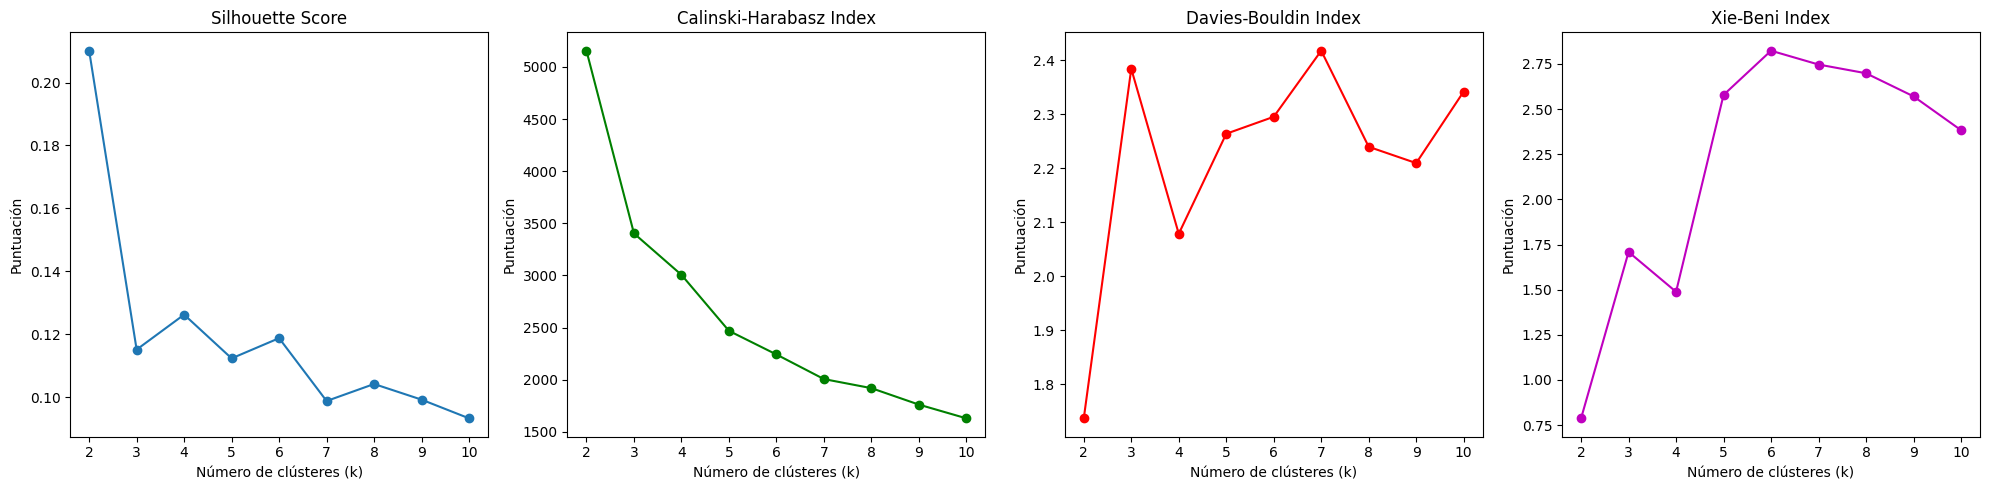

In [9]:
evaluar_indices_calidad(df_filtered, k_min=2, k_max=10, random_state=42)

## 2.4 Obtención de información de clusters -> mal

Es raro porque con normalized y filtered no es capaz de agrupar los datos pero con scaled y grouped, lo hace bastante bien a primera vista.

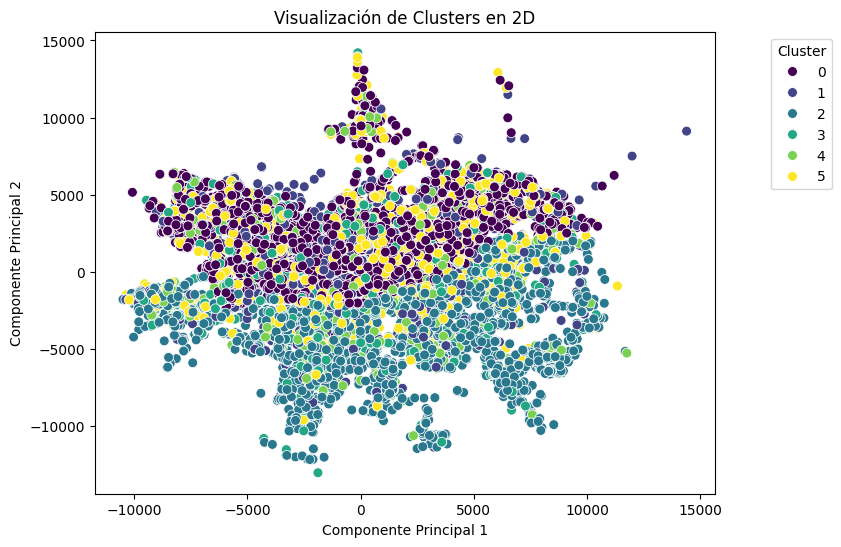

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Parámetros de K-Means
k = 6  # Número de clusters (puedes ajustarlo según sea necesario)
random_state = 42  # Para reproducibilidad

# Inicialización y ajuste del modelo K-Means
kmeans = KMeans(n_clusters=k, random_state=random_state)
kmeans.fit(scaled_df)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Aplicar PCA para reducir a 2 dimensiones
pca_2D = PCA(n_components=2)
X_2D = pca_2D.fit_transform(df_grouped)

# Visualización en 2D con colores según los clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_2D[:, 0], 
    y=X_2D[:, 1], 
    hue=labels, 
    palette='viridis', 
    s=50
)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Clusters en 2D')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Número de clusters que deseas (k)
k = 3  # Puedes cambiar este valor según lo que necesites

# Inicialización del modelo KMeans
kmeans = KMeans(n_clusters=k, random_state=42)

# Ajustar el modelo KMeans al DataFrame normalizado
kmeans.fit(df_filtered)

# Obtener las etiquetas (clusters asignados)
labels = kmeans.labels_

# Crear una copia explícita del DataFrame para evitar el SettingWithCopyWarning
df_filtered_copy = df_filtered.copy()

# Añadir las etiquetas de los clusters al DataFrame copiado
df_filtered_copy['Cluster'] = labels


In [13]:
# Crear un DataFrame con las etiquetas de los clusters
df_filtered_copy['Cluster'] = labels

# Resumen de las características por cluster
cluster_summary = df_filtered_copy.groupby('Cluster').mean()
cluster_summary


,cod_distrito,tipo_accidente,estado_meteorológico,coordenada_x_utm,coordenada_y_utm,fecha_month,fecha_day,hora_hour,hora_minute,sexo_Mujer,...,rango_edad_25-34,rango_edad_35-44,rango_edad_45-59,rango_edad_60+,tipo_persona_Conductor,tipo_persona_Pasajero,tipo_persona_Peatón,positiva_alcohol,cod_lesividad,mahalanobis_distance
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.650659,0.391841,0.216775,0.516522,0.391021,0.494056,0.494691,0.599547,0.445149,0.080535,...,0.057277,0.053384,0.103157,0.037876,0.100067,0.031606,0.012955,0.075497,0.144516,2.011596
1,0.149025,0.370053,0.209878,0.487213,0.394461,0.500897,0.487054,0.584455,0.448093,0.072669,...,0.070757,0.058277,0.111426,0.037798,0.098739,0.030206,0.012709,0.043270,0.161088,0.564306
2,0.515558,0.387185,0.207283,0.498014,0.384683,0.503904,0.480623,0.599427,0.439131,0.077320,...,0.067549,0.057090,0.101555,0.038437,0.102536,0.034408,0.013565,0.082799,0.150082,1.194383


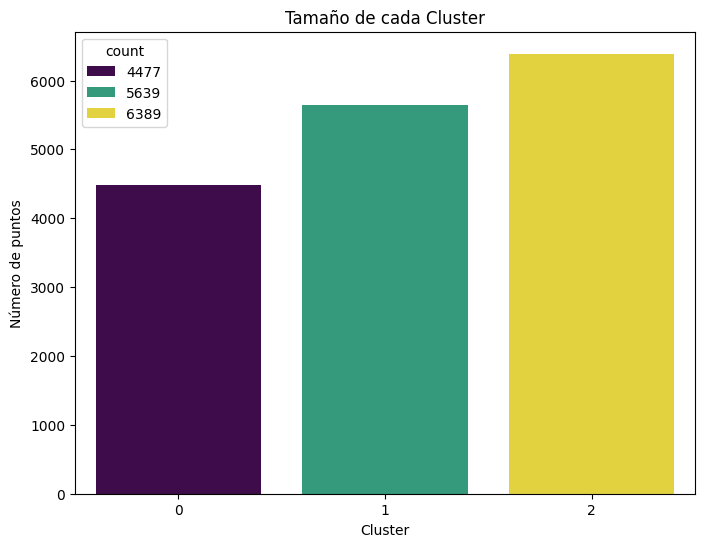

In [68]:
plt.figure(figsize=(8, 6))
cluster_sizes = df_filtered_copy['Cluster'].value_counts()
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis', hue=cluster_sizes)
plt.title('Tamaño de cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de puntos')
plt.show()

Clusters de tamaños desbalanceados podría ser un signo de agrupaciones desequilibradas o incluso de ruido en los datos. En este caso estan relativamente balanceados.

Como vamos a analizar a los viajeros, nos interesan solo las columnas de sexo, tipo de persona y edad.

In [ ]:

def calculate_distributions(df_grouped, labels):
    # Inicializa un diccionario para almacenar las distribuciones por cluster
    distributions = {}

    # Columnas numéricas para la distribución
    numeric_columns = ['sexo_Mujer', 'sexo_Hombre', 'sexo_Desconocido',
                       'rango_edad_0', 'rango_edad_0-17',
                       'rango_edad_18-24', 'rango_edad_25-34', 'rango_edad_35-44',
                       'rango_edad_45-59', 'rango_edad_60+', 'tipo_persona_Conductor',
                       'tipo_persona_Pasajero', 'tipo_persona_Peatón']

    

    # Inicializar un DataFrame vacío para cada columna numérica por cluster
    for col in numeric_columns:
        distributions[col] = pd.DataFrame(0, index=np.unique(labels), columns=[col])

    # Calcular la distribución por cluster
    for idx, label in enumerate(np.unique(labels)):
        cluster_data = df_grouped[labels == label]
        for col in numeric_columns:
            distributions[col].loc[label, col] = cluster_data[col].sum()

    return distributions


def plot_numeric_distributions(distributions):
    # Obtener los índices únicos de las distribuciones
    unique_indices = distributions[next(iter(distributions))].index

    for cluster in unique_indices:
        fig, ax = plt.subplots(figsize=(12, 6))

        col_names = list(distributions.keys())
        sums = [dist.loc[cluster].values[0] for col, dist in distributions.items()]

        colors = list(mcolors.TABLEAU_COLORS.values())

        ax.bar(col_names, sums, color=colors[:len(col_names)], alpha=0.7)

        for i, v in enumerate(sums):
            ax.text(i, v + max(sums) * 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

        ax.set_ylim(0, max(sums) * 1.1)

        ax.set_title(f'Suma de valores por columna numérica para Cluster {cluster}', fontsize=14)
        ax.set_ylabel('Suma', fontsize=12)
        ax.set_xlabel('Columnas', fontsize=12)
        ax.set_xticks(range(len(col_names)))
        ax.set_xticklabels(col_names, rotation=45, ha='right', fontsize=10)

        plt.tight_layout()
        plt.show()



### Tarea 3.5: 
Compara los resultados obtenidos con K-means y el clustering
aglomerativo/jerárquico. Discute las ventajas y desventajas de cada método en
diferentes tipos de datos.


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Apply Agglomerative Clustering
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_clusters = hierarchical.fit_predict(scaled_df)

# Compare silhouette scores
kmeans_silhouette = silhouette_score(scaled_df, clusters)
hierarchical_silhouette = silhouette_score(scaled_df, hierarchical_clusters)

print(f"K-means silhouette score: {kmeans_silhouette}")
print(f"Hierarchical silhouette score: {hierarchical_silhouette}")

K-means silhouette score: 0.12605079931226285
Hierarchical silhouette score: 0.13160510353379312


La primera diferencia que podemos apreciar es que el clustering jerárquico no necesita un número de clusters como parámetro en cambio, el k-means sí. Al trabajar con diferentes linkages y distancias hemos podido ver que el jerárquico trabaja mejor con datos circulares y agrupados naturalmente que con datos más densos y mensos dispersos. Los diferentes parámetros que acepta, da la posibilidad de ajustar el clustering a los datos. Además una ventaja es que los resultados son reproducibles y no dependen de un random_state para obtener los mismos resultados.
Como desventaja, el jerárquico es más lento y los dendrogramas que genera pueden llegar a ser difíciles de interpretar, sobretodo cuando las agrupaciones son complejas. 

Por otro lado, k-means es más rápido y tiene un funcionamiento más dinámico por su capacidad de ajustarse iterativamente. Está recomendado para datasets más grandes de los que el jerárquico es capaz de procesar. Sin embargo, necesita que los datos estén normalizados, que se establezca el número de clusters de antemano, asume que los clusters son esféricos y es muy sensible a outliers y al ruido.

En resumen, para datos pequeños y o de formas complejas, el jerárquico es más recomendable. Para datos más grandes pero casi obligatoriamente esféricos, el k-means es más adecuado.